# Part 1 (50 points)
In this part you will implement a neural network from scratch. You cannot use any existing
Deep Learning Framework. You can utilize NumPy and Pandas libraries to perform efficient
calculations. Refer to Lecture 5 slides for details on computations required.
Write a Class called NeuralNetwork that has at least the following methods (you are free to add
your own methods too):
a. Initialization method.
b. Forward propagation method that performs forward propagation calculations.
c. Backward propagation method that implements the backpropagation algorithm
discussed in class.
d. Train method that includes the code for gradient descent.
e. Cost method that calculates the loss function.
f. Predict method that calculates the predictions for the test set.
Test your NeuralNetwork Class with the dataset you selected. If the dataset is big, you may
notice inefficiencies in runtime. Try incorporating different versions of gradient descent to
improve that (Minibatch, Stochastic etc.). You may choose to use only a subset of your data for
this task (or any other technique). Explain which technique you followed and why.

## Comments:

For the below code, I mainly follow this link https://www.kaggle.com/code/ihalil95/building-two-layer-neural-networks-from-scratch and ChatGPT for guidance.

For the dataset, I decide to use MNIST: http://yann.lecun.com/exdb/mnist/
This dataset contains 60000 hand written digit examples in the training sets, and 10000 examples in the test set.

In [1]:
import numpy as np

class NeuralNetwork:
    def __init__(self, input_size, hidden_layer_size, output_size):
      # initialize the class
        self.params = self.initialize_parameters(input_size, hidden_layer_size, output_size)

    def initialize_parameters(self, input_size, hidden_layer_size, output_size):
      # Intialize parameters. Weights: normal distirbution. Bias: zeros.
        np.random.seed(1)
        W1 = np.random.randn(hidden_layer_size, input_size) * 0.01
        b1 = np.zeros((hidden_layer_size, 1))
        W2 = np.random.randn(output_size, hidden_layer_size) * 0.01
        b2 = np.zeros((output_size, 1))
        return {"W1": W1, "b1": b1, "W2": W2, "b2": b2}

    def relu(self, Z):
      # Relu activation
        return np.maximum(0, Z)

    def softmax(self, Z):
      # Softmax for multiclass classification
        e_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))
        return e_Z / np.sum(e_Z, axis=0, keepdims=True)

    def forward_propagation(self, X):
      # Perform forward progragation for two layer network
        W1, b1, W2, b2 = self.params['W1'], self.params['b1'], self.params['W2'], self.params['b2']

        Z1 = np.dot(W1, X) + b1
        A1 = self.relu(Z1)
        Z2 = np.dot(W2, A1) + b2
        A2 = self.softmax(Z2)

        self.cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}
        return A2

    def compute_cost(self, Y_hat, Y):
      # lost function: cross entropy loss
        m = Y.shape[1]
        cost = -np.sum(np.log(Y_hat) * Y) / m
        cost = np.squeeze(cost)
        return cost

    def relu_derivative(self, Z):
      # derivative of relu
        return Z > 0

    def backward_propagation(self, X, Y):
      # perform backward progagation
        W1, W2 = self.params['W1'], self.params['W2']
        Z1, A1, A2 = self.cache['Z1'], self.cache['A1'], self.cache['A2']
        m = X.shape[1]

        dZ2 = A2 - Y # A2: output of cross entropy loss. Y: one hot encoding format of true label.
        # They share same dimensionality, so direct difference works.
        dW2 = np.dot(dZ2, A1.T) / m
        db2 = np.sum(dZ2, axis=1, keepdims=True) / m
        dZ1 = np.dot(W2.T, dZ2) * self.relu_derivative(Z1)
        dW1 = np.dot(dZ1, X.T) / m
        db1 = np.sum(dZ1, axis=1, keepdims=True) / m

        self.grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}

    def update_parameters(self, learning_rate=0.01):
      # update parameters with learning rate
        for param in self.params:
            self.params[param] -= learning_rate * self.grads["d" + param]

    def predict(self, X):
      # prediction
        A2 = self.forward_propagation(X)
        return np.argmax(A2, axis=0)

    def fit(self, X, Y, iterations=1000, learning_rate=0.01):
      # traditional training using gradient descent
        for i in range(iterations):
            Y_hat = self.forward_propagation(X)
            cost = self.compute_cost(Y_hat, Y)
            self.backward_propagation(X, Y)
            self.update_parameters(learning_rate=learning_rate)
            if i % 100 == 0:
                print(f"Iteration {i} cost: {cost}")

    def fit_minibatch(self, X, Y, batch_size=32, iterations=1000, learning_rate=0.01):
      # training using minibatch
        m = X.shape[1]
        for i in range(iterations):
            # Shuffle the training data for every iteration (traditional minibatch)
            permutation = np.random.permutation(m)
            X_shuffled = X[:, permutation]
            Y_shuffled = Y[:, permutation]

            for j in range(0, m, batch_size):
                # Get the minibatch
                X_batch = X_shuffled[:, j:j+batch_size]
                Y_batch = Y_shuffled[:, j:j+batch_size]

                # Forward propagation
                Y_hat = self.forward_propagation(X_batch)

                # Backward propagation
                self.backward_propagation(X_batch, Y_batch)

                # Update parameters
                self.update_parameters(learning_rate=learning_rate)

            # Compute cost and print progress
            if i % 100 == 0:
                cost = self.compute_cost(Y_hat, Y_batch)
                print(f"Iteration {i}: Cost = {cost}")




In [2]:
from tensorflow.keras.datasets import mnist
import time

# Load the dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Normalize the images to have values between 0 and 1
X_train, X_test = X_train / 255.0, X_test / 255.0

# Flatten the images for the neural network
X_train_flatten = X_train.reshape(X_train.shape[0], -1).T
X_test_flatten = X_test.reshape(X_test.shape[0], -1).T

# Convert labels to one-hot encoding
from tensorflow.keras.utils import to_categorical

# Maybe not necessary, but no harm to implement because we are dealing with multiclass problem
y_train_encoded = to_categorical(y_train, num_classes=10).T
y_test_encoded = to_categorical(y_test, num_classes=10).T


# Initialize the neural network
input_size = X_train_flatten.shape[0]  # 784
hidden_layer_size = 128
output_size = 10 # 0 - 9 digits
network = NeuralNetwork(input_size, hidden_layer_size, output_size)

start = time.time()
# Train the network using traditional gradient descent
network.fit(X_train_flatten, y_train_encoded, iterations=2000, learning_rate=0.01)

end = time.time()
print("Total training time of traditional gradient descent: ", end - start)
# Evaluate the network
predictions = network.predict(X_test_flatten)
true_labels = np.argmax(y_test_encoded, axis=0)
accuracy = np.mean(predictions == true_labels) * 100
print(f"Test Accuracy: {accuracy}%")


11490434/11490434 [==============================] - 2s 0us/step
Iteration 0 cost: 2.3023489444931524
Iteration 100 cost: 2.2891630420409474
Iteration 200 cost: 2.2645120234682157
Iteration 300 cost: 2.212347581972457
Iteration 400 cost: 2.1098962676700608
Iteration 500 cost: 1.9368681002186778
Iteration 600 cost: 1.6979682002798884
Iteration 700 cost: 1.4401367513931542
Iteration 800 cost: 1.217365100570236
Iteration 900 cost: 1.0460598638753578
Iteration 1000 cost: 0.9181809289550497
Iteration 1100 cost: 0.8222191278108836
Iteration 1200 cost: 0.7490369438370504
Iteration 1300 cost: 0.6920774849168243
Iteration 1400 cost: 0.6467746861649456
Iteration 1500 cost: 0.6099819547314688
Iteration 1600 cost: 0.5795250864741937
Iteration 1700 cost: 0.5538881769341946
Iteration 1800 cost: 0.5319981717406853
Iteration 1900 cost: 0.513079740132881
Total training time of traditional gradient descent:  1595.6268944740295
Test Accuracy: 87.56%


In [3]:
from tensorflow.keras.datasets import mnist

# Load the dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Normalize the images to have values between 0 and 1
X_train, X_test = X_train / 255.0, X_test / 255.0

# Flatten the images for the neural network
X_train_flatten = X_train.reshape(X_train.shape[0], -1).T
X_test_flatten = X_test.reshape(X_test.shape[0], -1).T

# Convert labels to one-hot encoding
from tensorflow.keras.utils import to_categorical

y_train_encoded = to_categorical(y_train, num_classes=10).T
y_test_encoded = to_categorical(y_test, num_classes=10).T

# Load and preprocess MNIST data (assuming it's already loaded and preprocessed)
# X_train_flatten, y_train_encoded, X_test_flatten, y_test_encoded

# Initialize the neural network
input_size = X_train_flatten.shape[0]  # 784
hidden_layer_size = 128
output_size = 10 # 0 - 9 digits
network = NeuralNetwork(input_size, hidden_layer_size, output_size)

start = time.time()
# Train the network using minibatch with batch size 256
network.fit_minibatch(X_train_flatten, y_train_encoded, batch_size=256, iterations=2000, learning_rate=0.01)

end = time.time()

print("Total training time of mini batch gradient: ", end - start)
# Evaluate the network
predictions = network.predict(X_test_flatten)
true_labels = np.argmax(y_test_encoded, axis=0)
accuracy = np.mean(predictions == true_labels) * 100
print(f"Test Accuracy: {accuracy}%")

Iteration 0: Cost = 2.251438039179879
Iteration 100: Cost = 0.15363373820094722
Iteration 200: Cost = 0.06892955621804037
Iteration 300: Cost = 0.03231656078724808
Iteration 400: Cost = 0.10353118477941037
Iteration 500: Cost = 0.044485810708141275
Iteration 600: Cost = 0.051494615489537515
Iteration 700: Cost = 0.013866393656450914
Iteration 800: Cost = 0.007281254801145713
Iteration 900: Cost = 0.015764711518407127
Iteration 1000: Cost = 0.037912984834571124
Iteration 1100: Cost = 0.021827756945600043
Iteration 1200: Cost = 0.01859885618293126
Iteration 1300: Cost = 0.010326438159731723
Iteration 1400: Cost = 0.012429118559501897
Iteration 1500: Cost = 0.008193592483281989
Iteration 1600: Cost = 0.005276336228546629
Iteration 1700: Cost = 0.007328327594213736
Iteration 1800: Cost = 0.01831145766096291
Iteration 1900: Cost = 0.010566295251178711
Total training time of mini batch gradient:  2277.392800092697
Test Accuracy: 98.00999999999999%


## Explanation:

The accuracy of traditional gradient descent is 87.56% and the accuracy of mini batch gradient descent is 98.01%.

Here I choose minibatch to improve the performance because minibatch can make model learns more once a time comparing to stochastic gradient descent (SGD). Remember that we have images, with is a high dimensional matrix, and 10 classes versus two classes, that means the model needs to learn more details and extract more features to make successful classification. SGD might work as well, but will diverge if given only 2000 iteraions.

While with the same amount of 2000 iterations, mini batch improves the accuracy a lot, showing the efficiency of the mini batch gradient descent algorithm. However, the time is longer than the traditional one, probably depends on two reasons:
1. Colab GPU memory is big enough to hold all the data of MNIST, where MNIST is not a very huge dataset
2. I implement the traditional mini-batch algorithm (random indexing for every iteration), while in practice we usually do the indexing at the beginning and then keep the same indexing.

# Part 2

Task 1 (5 points): Assuming you are not familiar with the framework, in this part of the
homework you will present your research describing the resources you used to learn the
framework (must include links to all resources). Clearly explain why you needed a particular
resource for implementing a 2-layer Neural Network (NN). (Consider how you will keep track of
all the computations in a NN i.e., what libraries/tools do you need within this framework.)

I will use pytorch as the framework to code up a 2-layer Neural Network.
I will use this link as my starting point: https://pytorch.org/tutorials/beginner/pytorch_with_examples.html

This link contains several examples about tensor, forward pass, backward pass, and neural network layers, which are essential for constructing neural networks.

The second link that I follow is https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html

This link focuses more on how to construct neural networks by pytorch, instead of a general introduction by example from the first link.

Task 2 (35 points): Once you have figured out the resources you need for the project, you
should design and implement your project. The project must include the following steps (it’s
not limited to these steps):
1. Exploratory Data Analysis (Can include data cleaning, visualization etc.)
2. Perform a train-dev-test split.
3. Implement forward propagation (clearly describe the activation functions and other
hyper-parameters you are using).
4. Compute the final cost function.
5. Implement gradient descent (any variant of gradient descent depending upon your
data and project can be used) to train your model. In this step it is up to you as someone
in charge of their project to improvise using optimization algorithms (Adams, RMSProp
etc.) and/or regularization. Experiment with normalized inputs i.e. comment on how
your model performs when the inputs are normalized.
6. Present the results using the test set.
NOTE: In this step, once you have implemented your 2-layer network you may increase and/or
decrease the number of layers as part of the hyperparameter tuning process.

## data analysis:

One the following example is plotted below the cell.
According to the website http://yann.lecun.com/exdb/mnist/, there are 60,000 examples, and a test set of 10,000 example. I normalize the data in the transform below to make sure the neural network does not diverge because of large high dimensional features.

100%|██████████| 9912422/9912422 [00:00<00:00, 348362837.84it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 41713393.19it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 212986708.04it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 22980131.20it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



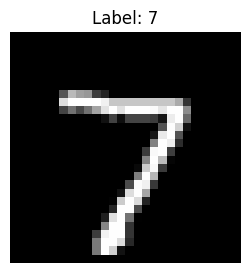

In [6]:
import matplotlib.pyplot as plt


# Load and preprocess the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
# Get one random sample from the test set
train_data = datasets.MNIST(root='.', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='.', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)


data, target = next(iter(test_loader))
data = data[0]
target = target[0]
# Visualize the image
plt.figure(figsize=(3, 3))
plt.imshow(data.squeeze().numpy(), cmap='gray')
plt.title(f'Label: {target.item()}')
plt.axis('off')
plt.show()

Here, I use two layers, the input layer dimension is 28*28 (MNIST image size), the hidden layer is 512, and I use ReLU activation.

In [8]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim

class NeuralNetworkPytorch(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [5]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")




Using cuda device


In [13]:
# Load and preprocess the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_data = datasets.MNIST(root='.', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='.', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)

# Initialize the model, loss function, and optimizer
model = NeuralNetworkPytorch().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 5
for epoch in range(epochs):
    model.train()
    for batch_idx, (data, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(data.to(device)).to(device)
        loss = criterion(outputs, targets.to(device))
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")



Epoch 1/5, Batch 0/938, Loss: 2.3405
Epoch 1/5, Batch 100/938, Loss: 0.1918
Epoch 1/5, Batch 200/938, Loss: 0.1724
Epoch 1/5, Batch 300/938, Loss: 0.0896
Epoch 1/5, Batch 400/938, Loss: 0.1028
Epoch 1/5, Batch 500/938, Loss: 0.1586
Epoch 1/5, Batch 600/938, Loss: 0.0771
Epoch 1/5, Batch 700/938, Loss: 0.2215
Epoch 1/5, Batch 800/938, Loss: 0.0527
Epoch 1/5, Batch 900/938, Loss: 0.0889
Epoch 2/5, Batch 0/938, Loss: 0.0666
Epoch 2/5, Batch 100/938, Loss: 0.0582
Epoch 2/5, Batch 200/938, Loss: 0.0605
Epoch 2/5, Batch 300/938, Loss: 0.1344
Epoch 2/5, Batch 400/938, Loss: 0.0366
Epoch 2/5, Batch 500/938, Loss: 0.0799
Epoch 2/5, Batch 600/938, Loss: 0.0573
Epoch 2/5, Batch 700/938, Loss: 0.0556
Epoch 2/5, Batch 800/938, Loss: 0.0418
Epoch 2/5, Batch 900/938, Loss: 0.0834
Epoch 3/5, Batch 0/938, Loss: 0.1050
Epoch 3/5, Batch 100/938, Loss: 0.0188
Epoch 3/5, Batch 200/938, Loss: 0.0855
Epoch 3/5, Batch 300/938, Loss: 0.0879
Epoch 3/5, Batch 400/938, Loss: 0.0697
Epoch 3/5, Batch 500/938, Loss:

In [16]:
# Evaluate the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, targets in test_loader:
        outputs = model(data.to(device)).to(device)
        _, predicted = torch.max(outputs, dim=1)
        total += targets.size(0)
        correct += (predicted == targets.to(device)).sum().item()

    accuracy = correct / total
    print(f"Accuracy on the test set: {accuracy:.2%}")

Accuracy on the test set: 97.73%


Task 3 (10 points): In task 2 describe how you selected the hyperparameters. What was the
rationale behind the technique you used? Did you use regularization? Why, or why not? Did you use
an optimization algorithm? Why or why not?

I use 512 as the hidden size of neural network, 0.001 as the learning rate, and 64 as the batchsize to implement minibatch optimization algorithm. Besides minibatch optimization algorithm, I use the Adam optimizer mentioned a couple of lectures ago. I also normalize the images before inputting into the network, where the normalizing constants transforms.Normalize((0.1307,), (0.3081,)) coming from this link: https://stackoverflow.com/questions/63746182/correct-way-of-normalizing-and-scaling-the-mnist-dataset

512 as hidden size because the input size is 28 * 28 = 784, which a large hidden size neural network can capture more features.
0.001 as the learning rate works because a lot of features need to be learn by network, so a small learning rating will serve better to learn features slowly. Since the dataset is big enough, overfitting is a minor issue to consider.

Adam is a good optimizer to perform. It's a popular optimizer, works well with learning rate 0.001 or even smaller learning rate, and general performs well based on different implementations of network training online.

For the nomarlizing constant, it's a fix number, I follow the convention. Also, this number is computed.

The following task is for Graduate level only (6000 level):
Task 4 (100 points): Create another baseline model (can be any model we covered so far except
a deep learning model). Using the same training data (as above) train your model and evaluate
results using the test set. Compare the results of both models (the Neural Network and the
baseline model). What are the reasons for one model performing better (or not) than the
other? Explain.

For the baseline model, I am going to use One VS All logistic regression model to classify digits, using sklearn package.

Reference from: https://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_logistic_regression_mnist.html

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import time

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

# # Load MNIST dataset
# mnist = fetch_openml('mnist_784', version=1)
# X, y = mnist['data'], mnist['target']

# Split dataset into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Load data from https://www.openml.org/d/554

t0 = time.time()
train_samples = 60000

X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_samples, test_size=10000
)


# Train one-vs-all logistic regression classifier for each digit
classifiers = []
for digit in range(10):
    y_train_digit = (y_train == str(digit)).astype(int)
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train_digit)
    classifiers.append(clf)

# Predict using all classifiers
predictions = np.vstack([clf.predict(X_test) for clf in classifiers])

# Select the class with the highest probability as the predicted class
y_pred = np.argmax(predictions, axis=0)

# Evaluate accuracy
accuracy = accuracy_score(y_test.astype(int), y_pred)
print(f"Accuracy: {accuracy:.4f}")


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-p

Accuracy: 0.8555


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The accuracy by neural network is 97.73% and the accuracy of Logistic regression is 85.55%.

Overhere, again, I treat the MNIST as a multiclass problem by separating one class from all the other classes, using One VS All approach. Then, I implement logistic regression based on One VS All approach.

As you can see, two layer network performs much better than logistic regression becuase two layer network can capture more features than simple logistic regression.